# [종합실습-1] Used Cars Price Prediction

- Theme : The price prediction of the used car  
- 비즈니스 상황 : POS_Cars㈜ 는 이 인도의 중고차 시장에 뛰어들어 신규사업을 목표로 
- 하는 신생  스타트업이다.    
- POS_Cars㈜는 인도자동차 시장에 진출하여 경쟁력 확보와 수익성을 향상을 위하여 중고차 가격을  효과적으로 
  예측할 수 있는  “핵심영향인자 도출과 가격예측 모델 개발”이 필요

### STEP 0 패키지 불러오기/한글 폰트 적용

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 맑은 고딕 적용
matplotlib.rc("font", family = "Malgun Gothic")
# 음수 표시
matplotlib.rc("axes", unicode_minus = False)

### STEP 1 데이터 구성하기

In [3]:
df_raw = pd.read_csv("./usedcars_1/car_data.csv")
data_dict = pd.read_excel("./usedcars_1/data dictionary.xlsx")

In [4]:
data_dict

,No,Attribute,Description
0,1,Price,"중고차 가격, The price of the used car in 1,000 won"
1,2,Name,"자동차의 브랜드와 모델 이름, Name of the car which includ..."
2,3,Location,"자동차를 팔거나 구매할 수 있는 위치, The location in which t..."
3,4,Year,"모델의 년도 혹은 버전 , The year or edition of the model"
4,5,Kilometers_Driven,"이전 소유주의 차량 주행거리(KM), The total kilometers dri..."
5,6,Fuel_Type,"자동차의 사용연료의 종류, The type of fuel used by the ca..."
6,7,Transmission,"자동차의 사용 변속기의 종류, The type of transmission used..."
7,8,Owner_Type,"소유권이 직접 소유인지, 중고 소유인지 여부, Whether the ownershi..."
8,9,Mileage,"자동차 회사가 제공하는 표준주행거리(kmpl 또는 km/kg 단위), \nThe..."
9,10,Engine,"엔진의 배기량(cc), The displacement volume of the e..."


In [5]:
df_raw.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN


   [참고]
   - KMPL : Kilometers Per Lite
   - km/kg : Kilometers Per Kilogram
   - 1 liter : 1 kilogram

In [6]:
print("Raw Data:", df_raw.shape)

Raw Data: (7253, 13)


In [7]:
df_raw['Name'].value_counts()

Mahindra XUV500 W8 2WD                             55
Maruti Swift VDI                                   49
Maruti Swift Dzire VDI                             42
Honda City 1.5 S MT                                39
Maruti Swift VDI BSIV                              37
                                                   ..
Hyundai i20 Asta (o)                                1
BMW 5 Series 2003-2012 530d                         1
Tata Tiago 1.05 Revotorq XT Option                  1
Land Rover Range Rover 3.6 TDV8 Vogue SE Diesel     1
Toyota Fortuner 4x2 MT TRD Sportivo                 1
Name: Name, Length: 2041, dtype: int64

### STEP 1.  Data Preprocessing

- 단위와 같이 표현되어 있는 수치형 변수 처리

In [8]:
# 분할, 구분자를 이용하여 새로운 컬럼을 생성
df_raw['Mileage']=df_raw['Mileage'].str.replace('kmpl','')
df_raw['Mileage']=df_raw['Mileage'].str.replace('km/kg','')
df_raw['Engine']=df_raw['Engine'].str.replace('CC','')
df_raw['Power']=df_raw['Power'].str.replace('bhp','')

In [9]:
df_raw['Mileage']=df_raw['Mileage'].str.replace('null','0')
df_raw['Engine']=df_raw['Engine'].str.replace('null','0')
df_raw['Power']=df_raw['Power'].str.replace('null','0')

In [10]:
# 'New_Price' 삭제
df_raw.drop(columns = ['New_Price'], inplace = True)

- Data Type 확인 및 변경

In [11]:
df_raw.dtypes

Name                  object
Location              object
Price                float64
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage               object
Engine                object
Power                 object
Seats                float64
dtype: object

In [12]:
# object data type을 category data type으로 변경
df_raw["Fuel_Type"] = df_raw["Fuel_Type"].astype("category")
df_raw["Transmission"] = df_raw["Transmission"].astype("category")
df_raw["Owner_Type"] = df_raw["Owner_Type"].astype("category")

In [13]:
# object data type을 float data type으로 변경
df_raw['Mileage']=df_raw['Mileage'].astype(float)
df_raw['Engine']=df_raw['Engine'].astype(float)
df_raw['Power']=df_raw['Power'].astype(float)

In [14]:
# Data Type 재확인 
df_raw.dtypes

Name                   object
Location               object
Price                 float64
Year                    int64
Kilometers_Driven       int64
Fuel_Type            category
Transmission         category
Owner_Type           category
Mileage               float64
Engine                float64
Power                 float64
Seats                 float64
dtype: object

- 결측치 확인 및 처리

In [15]:
df_raw.isnull().sum()

Name                    0
Location                0
Price                1053
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                  46
Seats                  53
dtype: int64

In [16]:
# data가 '0' 인 data 처리
df_raw.loc[df_raw.Mileage==0,'Mileage']= np.nan
df_raw.loc[df_raw.Engine==0,'Engine']= np.nan
df_raw.loc[df_raw.Power==0,'Power']= np.nan

In [17]:
# 결측치에 대해 평균값으로 대체 처리
df_raw['Mileage']=df_raw['Mileage'].fillna(df_raw['Mileage'].mean())
df_raw['Engine']=df_raw['Engine'].fillna(df_raw['Engine'].mean())
df_raw['Power']=df_raw['Power'].fillna(df_raw['Power'].mean())
df_raw['Seats']=df_raw['Seats'].fillna(df_raw['Seats'].mean())

In [18]:
# Price 결측치 제거 : Brand,자동차 제원치가 다양하여 제거 결정
df_raw.dropna(inplace = True)

In [19]:
# Check Name column uniques
df_raw['Name'].nunique()

1921

In [20]:
df_raw.isnull().sum()

Name                 0
Location             0
Price                0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
dtype: int64

In [21]:
df_raw['Name']

0                   Maruti Wagon R LXI CNG
1         Hyundai Creta 1.6 CRDi SX Option
2                             Honda Jazz V
3                        Maruti Ertiga VDI
4          Audi A4 New 2.0 TDI Multitronic
                       ...                
7228    Tata Tiago 1.05 Revotorq XT Option
7231     Ford EcoSport 1.5 Petrol Ambiente
7232                Jeep Compass 1.4 Sport
7235              Maruti Vitara Brezza ZDi
7236          Hyundai Elite i20 Magna Plus
Name: Name, Length: 6200, dtype: object

In [22]:
# 'Name'변수에서 Brand 명 추출(파생변수 생성)하고 'Name'변수 제거
df_raw['Brand'] = df_raw['Name'].apply(lambda x : x.split()[0])

In [23]:
df_raw['Brand']

0        Maruti
1       Hyundai
2         Honda
3        Maruti
4          Audi
         ...   
7228       Tata
7231       Ford
7232       Jeep
7235     Maruti
7236    Hyundai
Name: Brand, Length: 6200, dtype: object

In [24]:
df_raw['Brand'].nunique()

30

In [25]:
df_raw.drop(columns = ['Name'], inplace = True) 

In [26]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6200 entries, 0 to 7236
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Location           6200 non-null   object  
 1   Price              6200 non-null   float64 
 2   Year               6200 non-null   int64   
 3   Kilometers_Driven  6200 non-null   int64   
 4   Fuel_Type          6200 non-null   category
 5   Transmission       6200 non-null   category
 6   Owner_Type         6200 non-null   category
 7   Mileage            6200 non-null   float64 
 8   Engine             6200 non-null   float64 
 9   Power              6200 non-null   float64 
 10  Seats              6200 non-null   float64 
 11  Brand              6200 non-null   object  
dtypes: category(3), float64(5), int64(2), object(2)
memory usage: 503.1+ KB


In [27]:
# df_raw['Price'] = df_raw['Price'].fillna(df_raw['Price'].median())

In [28]:
df_raw.isnull().sum()

Location             0
Price                0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Brand                0
dtype: int64

In [29]:
# Car_age 변수 파생 : 현재 연도와 나이 열을 새로 생성, 현재 연도는 2023년이고 연령 열은 자동차 나이= 현재 연도가 됨
df_raw['Current_year'] = 2023
df_raw['Car_age'] = df_raw['Current_year']-df_raw['Year']
df_raw.drop(columns=['Current_year'], axis=1, inplace = True)
df_raw.head()

,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Car_age
0,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,Maruti,13
1,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,Hyundai,8
2,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,Honda,12
3,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,Maruti,11
4,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,Audi,10


- 이상치 제거

In [30]:
df_raw.describe()

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Car_age
count,6200.000000,6200.000000,6.200000e+03,6200.000000,6200.000000,6200.000000,6200.000000,6200.000000
mean,14912.514750,2013.434194,5.815738e+04,18.384720,1619.983814,113.300417,5.278508,9.565806
std,17674.318464,3.271969,9.010627e+04,4.156986,599.744181,53.540989,0.805628,3.271969
min,7.080000,1998.000000,1.710000e+02,6.400000,72.000000,34.200000,0.000000,4.000000
25%,5365.360000,2012.000000,3.300000e+04,15.400000,1198.000000,77.750000,5.000000,7.000000
50%,8814.520000,2014.000000,5.251450e+04,18.346527,1493.000000,98.600000,5.000000,9.000000
75%,15869.972500,2016.000000,7.227750e+04,21.100000,1968.000000,138.030000,5.000000,11.000000
max,245273.600000,2019.000000,6.500000e+06,33.540000,5998.000000,616.000000,10.000000,25.000000


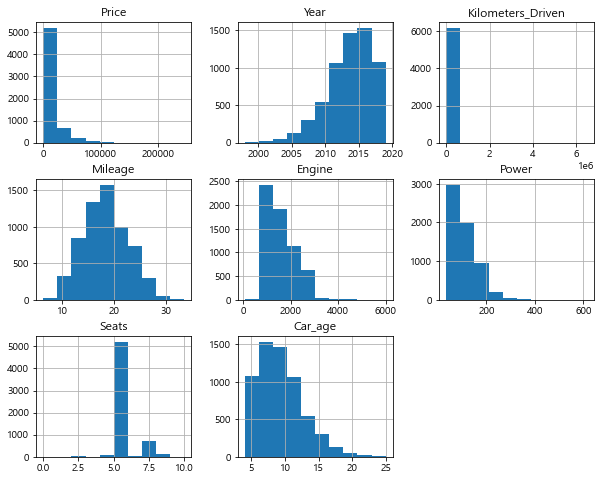

In [31]:
df_raw.hist(figsize = (10, 8))
plt.show()

    ▶ Price는 2.45억원으로 중고차로는 너무 높으며, 특이치로 보임
    ▶ Year는 1998년~2019년까지이며, Car_age는 4년차부터 25년차까지임
    ▶ Kilometers_Driven(주행거리)는 171Km~6,500,000Km, 평균은 58,157Km이고, 300만 Km 이상은 특이치로 보임
    ▶ Mileage는 거의 정상적으로 분포를 보임.
    ▶ Engine은 오른쪽으로 치우쳐 있고 상단과 하단에 특이치가 있음
    ▶ Price, Power, Car_age는 왼쪽으로 치우쳐 있음

In [32]:
# 목표변수(Price) 이상치 처리

<AxesSubplot:>

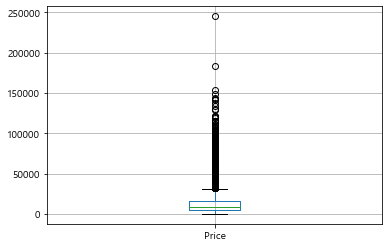

In [33]:
# Price 분포 확인
df_raw.boxplot('Price')

       ▶ Price 이상치 존재 

In [34]:
# Price 가 1.8억 이상 이면 제외 (중고차로써는 너무 비쌈)
df_raw = df_raw[df_raw['Price'] < 180000]
df_raw.reset_index(drop=True, inplace=True)
df_raw.head(2)

,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Car_age
0,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,Maruti,13
1,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,Hyundai,8


<AxesSubplot:>

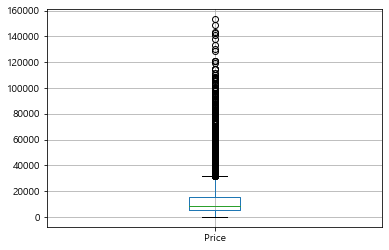

In [35]:
df_raw.boxplot('Price')

<AxesSubplot:xlabel='Price', ylabel='Density'>

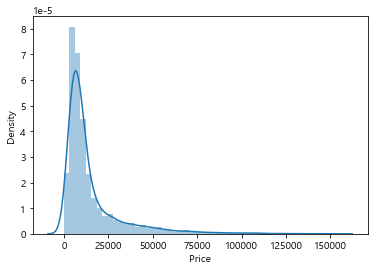

In [36]:
sns.distplot(df_raw['Price'])

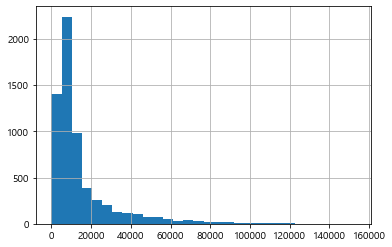

In [37]:
df_raw['Price'].hist(bins=30)
plt.show()

     ▶ Price가 왼쪽으로 기울어져 있음

In [38]:
# Price Log 변환 및 정규성 확인

<AxesSubplot:>

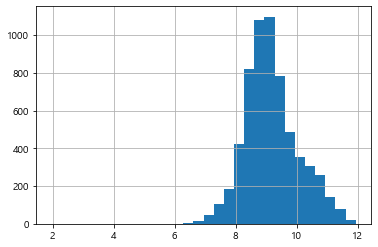

In [39]:
df_raw['Price'] = np.log(df_raw['Price'])
df_raw['Price'].hist(bins=30)

In [40]:
# 정규성 검정 : Anderson-Daring Test
df_norm = stats.anderson(df_raw['Price'], dist='norm')
print(df_norm)

AndersonResult(statistic=42.482179460611405, critical_values=array([0.576, 0.656, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


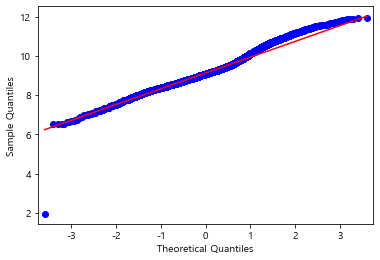

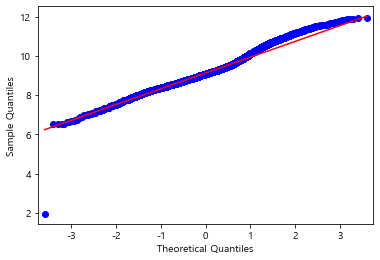

In [41]:
from statsmodels.api import qqplot

# 잔차 정규성 검정:Q-Q plot. s-standardized line, 
# r-regression line, q-quartiles
qqplot(df_raw['Price'], line = "q")

      ▶ Price 정규성 만족

In [42]:
# Year 등 설명변수들의 이상치 확인 및 처리

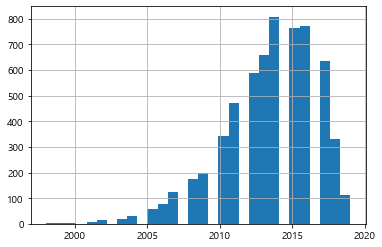

In [43]:
# Year 분포 확인
df_raw['Year'].hist(bins=30)
plt.show()

<AxesSubplot:>

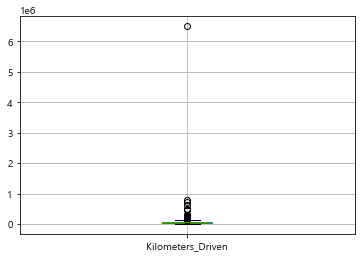

In [44]:
# 'Kilometers_Driven 분포 확인
df_raw.boxplot('Kilometers_Driven')

         ▶ Kilometers_Driven 이상치 존재

<AxesSubplot:>

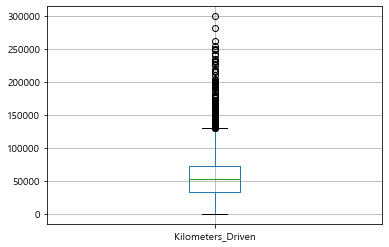

In [45]:
# 'Kilometers_Driven변수가 100만 이상 제외
df_raw=df_raw[df_raw['Kilometers_Driven'] < 300000]
df_raw.reset_index(drop=True, inplace=True)
df_raw.boxplot('Kilometers_Driven')

<AxesSubplot:xlabel='Kilometers_Driven', ylabel='Count'>

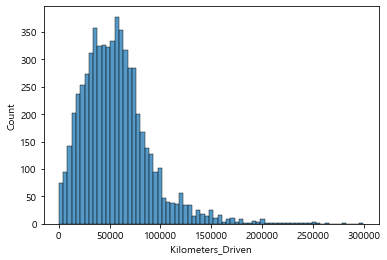

In [46]:
# Kilometers_Driven 분포 확인
sns.histplot(df_raw, x='Kilometers_Driven')

<AxesSubplot:xlabel='Mileage', ylabel='Count'>

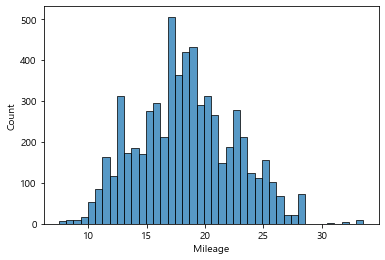

In [47]:
# Mileage 분포
sns.histplot(df_raw, x='Mileage')

<AxesSubplot:xlabel='Engine', ylabel='Count'>

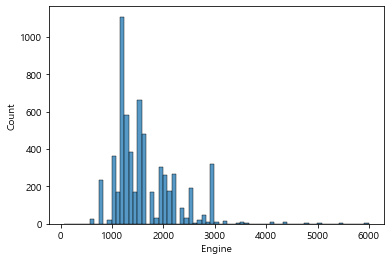

In [48]:
# Engine 성능 분포 확인
sns.histplot(df_raw, x='Engine')

<AxesSubplot:xlabel='Power', ylabel='Count'>

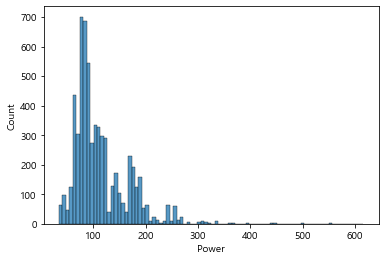

In [49]:
# Power 분포 확인
sns.histplot(df_raw, x='Power')

        ▶ Power에 이상치 존재 

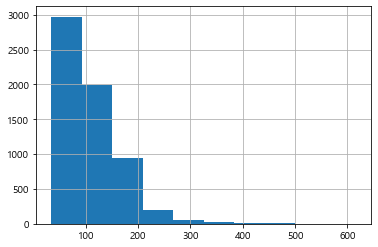

In [50]:
df_raw['Power'].hist()
plt.show()

<AxesSubplot:>

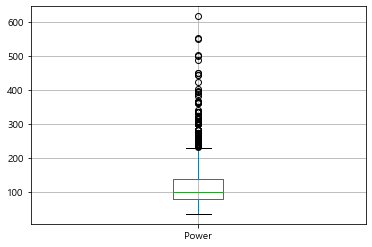

In [51]:
df_raw.boxplot('Power')

<AxesSubplot:>

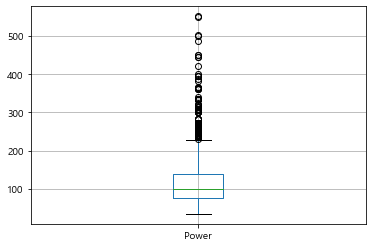

In [52]:
# Power 변수 1600 이상 제외
df_raw=df_raw[df_raw['Power'] < 600]
df_raw.reset_index(drop=True, inplace=True)
df_raw.boxplot('Power')

<AxesSubplot:>

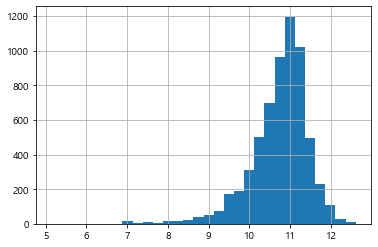

In [53]:
df_raw['Kilometers_Driven'] = np.log(df_raw['Kilometers_Driven'])
df_raw['Kilometers_Driven'].hist(bins=30)

<AxesSubplot:>

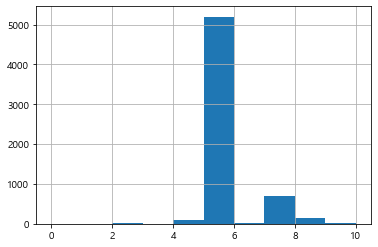

In [54]:
# Seats 분포 확인
df_raw['Seats'].hist()

<AxesSubplot:>

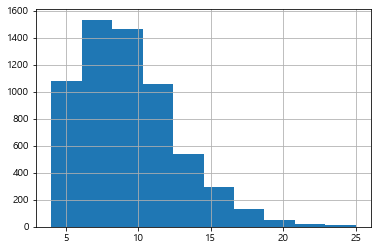

In [55]:
# Car_age 분포 확인
df_raw['Car_age'].hist()

### STEP 3. EDA – 그래프 분석

In [56]:
# Brand 카운트
df_raw['Brand'].value_counts()

Maruti           1254
Hyundai          1126
Honda             621
Toyota            423
Mercedes-Benz     325
Volkswagen        319
Ford              304
Mahindra          282
BMW               272
Audi              241
Tata              194
Skoda             181
Renault           151
Chevrolet         121
Nissan             95
Land               59
Jaguar             43
Mitsubishi         34
Fiat               31
Mini               29
Volvo              21
Jeep               19
Porsche            18
Datsun             17
Force               3
ISUZU               3
Bentley             1
Ambassador          1
Smart               1
Name: Brand, dtype: int64

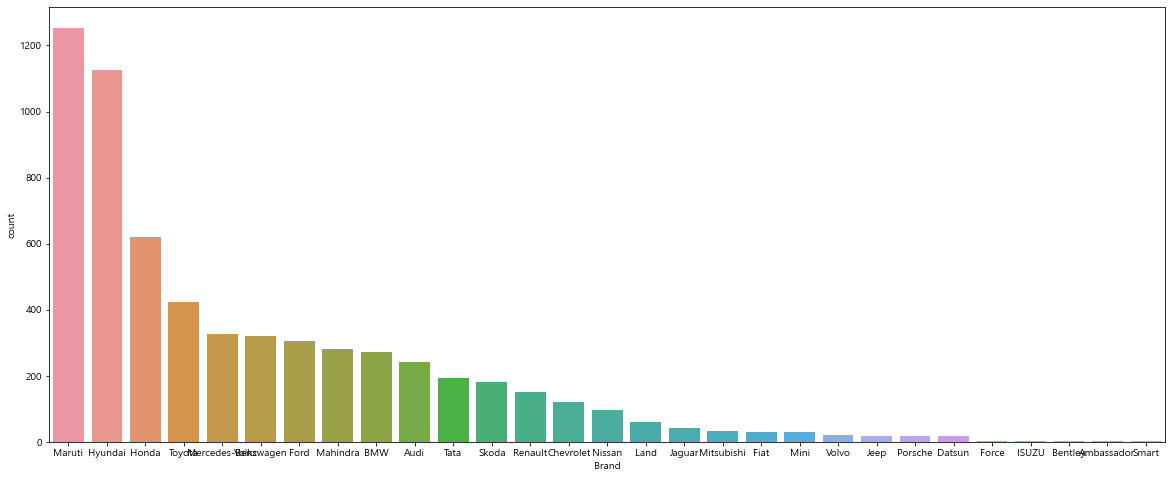

In [57]:
# Brand 분포 확인
plt.figure(figsize=(20,8))
sns.countplot(x='Brand', data=df_raw, order = df_raw['Brand'].value_counts().index)
plt.show()

    ▶ 자동차 Brand별 규모 확인 : Maruti > Hyundai > Honda > Toyota > Mercedes-Benz > Volkswagen > Ford  

In [58]:
# Location 카운트
df_raw['Location'].value_counts()

Mumbai        817
Hyderabad     758
Kochi         676
Coimbatore    664
Pune          632
Delhi         571
Kolkata       550
Chennai       502
Jaipur        423
Bangalore     363
Ahmedabad     233
Name: Location, dtype: int64

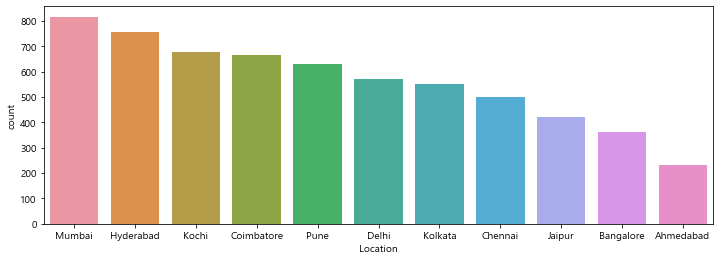

In [59]:
# Location 분포 확인
plt.figure(figsize=(12,4))
sns.countplot(x='Location', data=df_raw, order=df_raw['Location'].value_counts().index)
plt.show()

     ▶ 자동차 구매/판매 Location별 규모 확인: Mumbai > Hyderabad > Kochi > Coimbatore > Pune > Delhi

In [60]:
# Fuel_Type 카운트
df_raw['Fuel_Type'].value_counts()

Diesel      3295
Petrol      2825
CNG           57
LPG           10
Electric       2
Name: Fuel_Type, dtype: int64

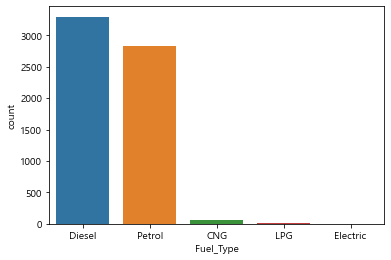

In [61]:
# Fuel_Type 분포 확인
sns.countplot(x='Fuel_Type', data=df_raw, order=df_raw['Fuel_Type'].value_counts().index)
plt.show()

      ▶ Fuel_Type은 주로 Diesel(3295대), Petrol(2825대)이 차지함

In [62]:
# Transmission 카운트
df_raw['Transmission'].value_counts()

Manual       4411
Automatic    1778
Name: Transmission, dtype: int64

<AxesSubplot:xlabel='Transmission', ylabel='count'>

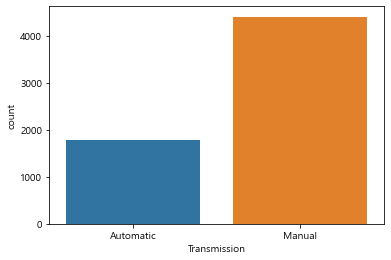

In [63]:
# Transmission 분포
sns.countplot(x='Transmission',  data=df_raw)

      ▶ Transmission은 Manual(5204대), Automatic(2049대)중에서 72%가 Manual임 

In [64]:
# Owner_Type 카운트
df_raw['Owner_Type'].value_counts()

First             5086
Second             982
Third              112
Fourth & Above       9
Name: Owner_Type, dtype: int64

<AxesSubplot:xlabel='Owner_Type', ylabel='count'>

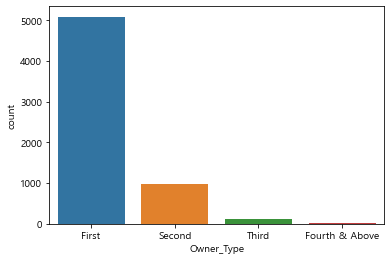

In [65]:
# Owner_Type 분포
sns.countplot(x='Owner_Type', data=df_raw, order=df_raw['Owner_Type'].value_counts().index)

      ▶ Owner_Type 은 First > Second > Third > Fourth & Above 순서임 

- 선형관계 확인: 산점도 및 상관계수 (전체 숫자형 변수)

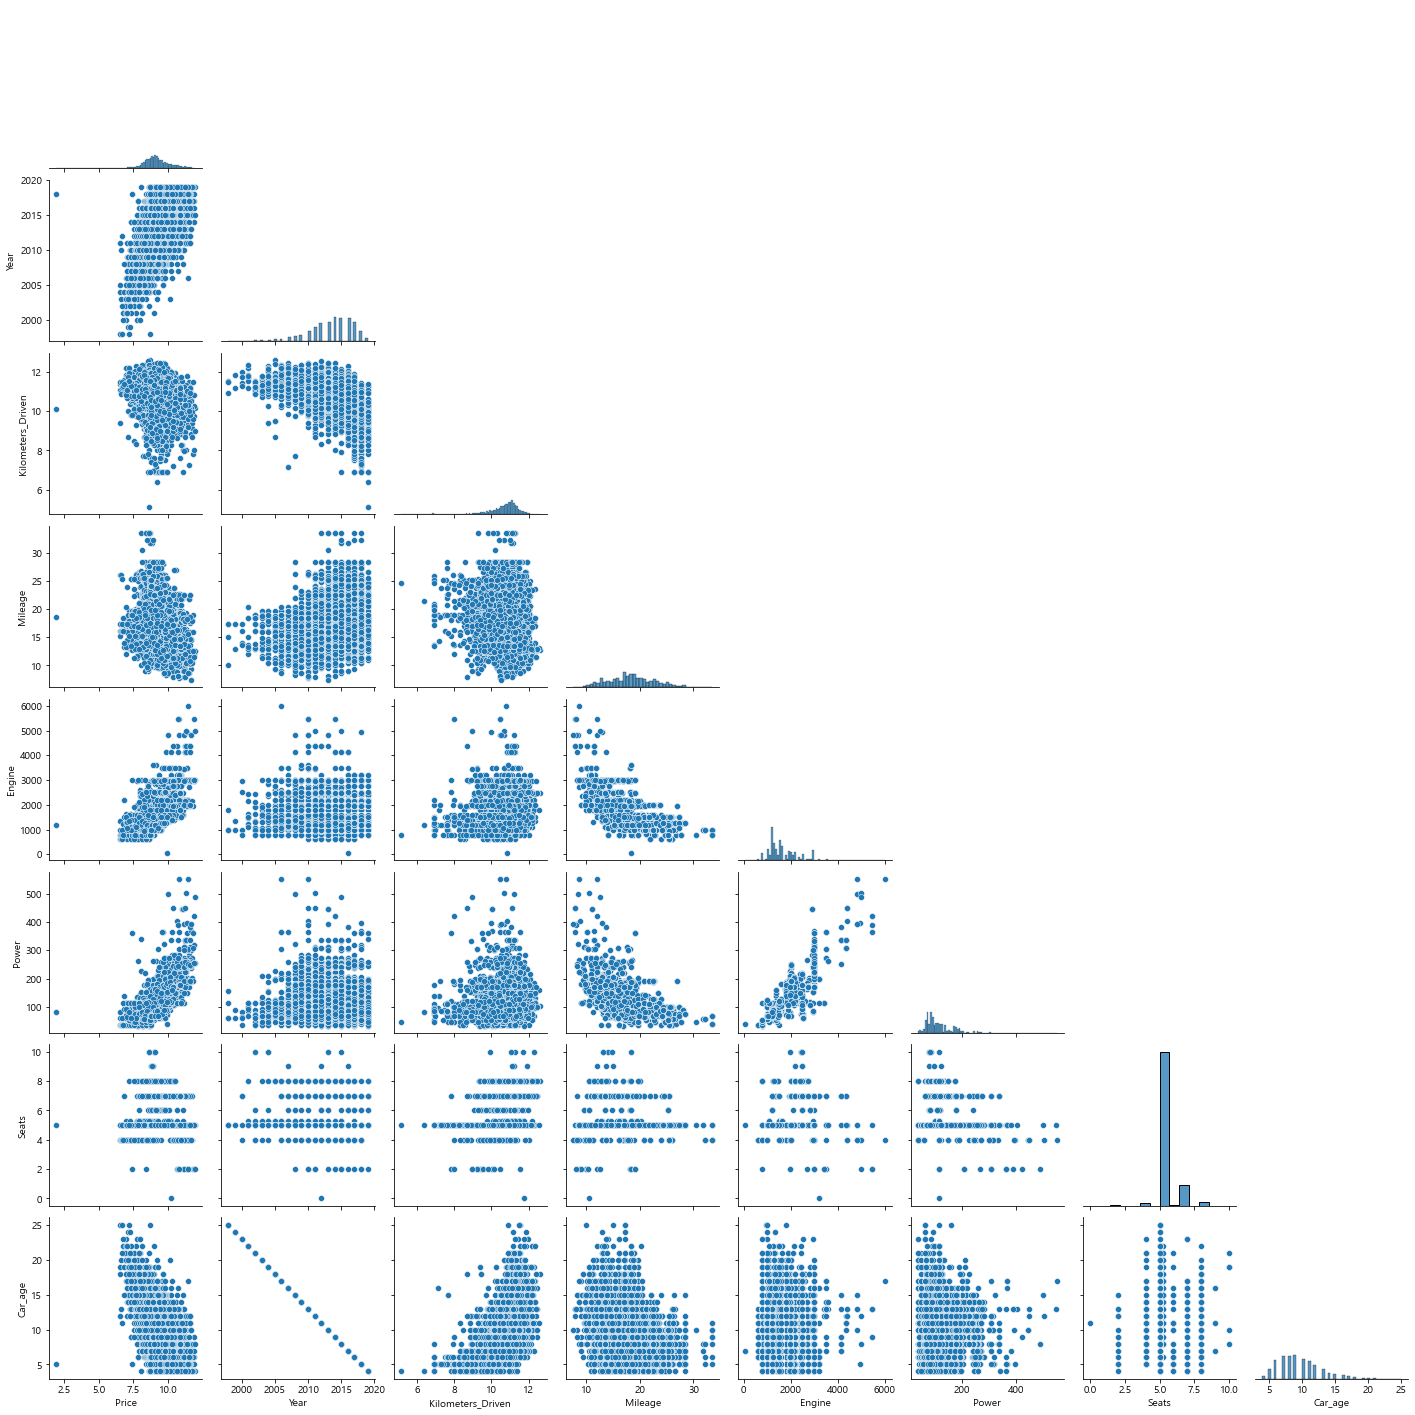

In [66]:
# Matrix Plot Analysis
sns.pairplot(data=df_raw , corner=True)
plt.show()

In [67]:
# Correlation Analysis
df_raw.corr()

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Car_age
Price,1.000000,0.499524,-0.204782,-0.290326,0.669464,0.738620,0.166187,-0.499524
Year,0.499524,1.000000,-0.509348,0.291857,-0.053979,0.013662,0.010419,-1.000000
Kilometers_Driven,-0.204782,-0.509348,1.000000,-0.136581,0.152885,0.019314,0.190809,0.509348
Mileage,-0.290326,0.291857,-0.136581,1.000000,-0.640539,-0.548556,-0.347686,-0.291857
Engine,0.669464,-0.053979,0.152885,-0.640539,1.000000,0.856269,0.400717,0.053979
Power,0.738620,0.013662,0.019314,-0.548556,0.856269,1.000000,0.105531,-0.013662
Seats,0.166187,0.010419,0.190809,-0.347686,0.400717,0.105531,1.000000,-0.010419
Car_age,-0.499524,-1.000000,0.509348,-0.291857,0.053979,-0.013662,-0.010419,1.000000


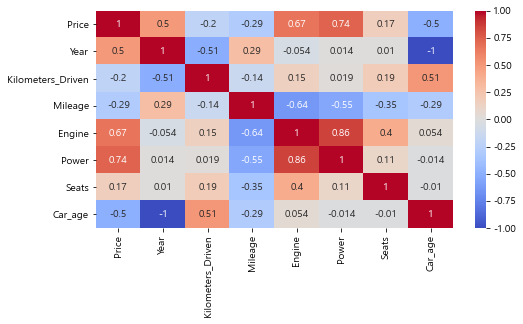

In [68]:
# heatmap 분석
plt.figure(figsize=(8,4))
sns.heatmap(df_raw.corr(),annot=True, cmap='coolwarm') # 'RdYlGn'
plt.show()

      ▶ Price는  Power와 r=0.74, Engine과 r=0.67, Year와 r=0.5의 양의 상관 관계이고, 
          Car_age와 r=-0.5, Kilometer_driven, Mileage과는 음의 상관 관계
      ▶ Engine은 Power와 r=0.86으로 강한 양의 상관 관계
      ▶ Mileage는 Engine과 r=-0.64, Power와 r=-0.55, Car_age와 r=-0.29의 음의 상관 관계

- 목표변수와 설명변수와의 관계 분석

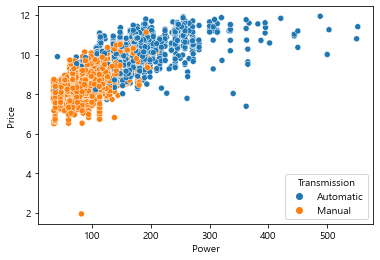

In [69]:
# Price vs Power
sns.scatterplot(x='Power', y='Price', hue='Transmission', data=df_raw)
plt.show()

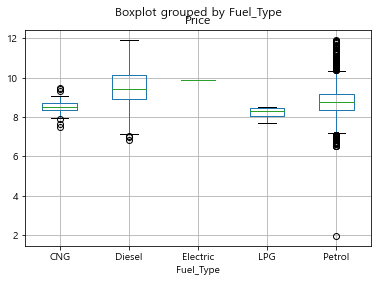

In [70]:
# Price vs Fuel_Type
df_raw.boxplot(column = "Price", by='Fuel_Type')
plt.show()

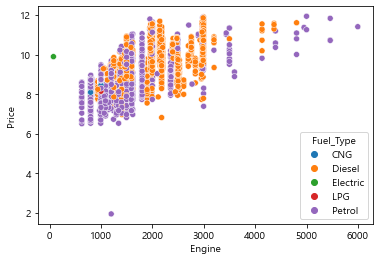

In [71]:
# Price vs Engine
sns.scatterplot(x='Engine', y='Price', hue='Fuel_Type', data=df_raw)
plt.show()

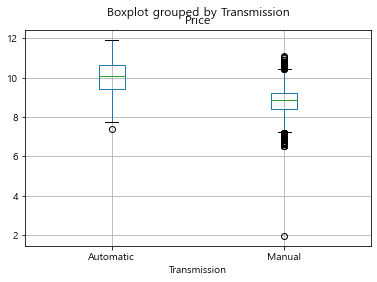

In [72]:
# Price vs Transmission
df_raw.boxplot(column = "Price", by='Transmission')
plt.show()

<AxesSubplot:xlabel='Year', ylabel='Price'>

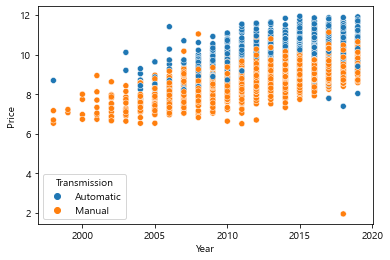

In [73]:
# Price vs Year
sns.scatterplot(x='Year', y='Price', hue='Transmission', data=df_raw)

<AxesSubplot:xlabel='Car_age', ylabel='Price'>

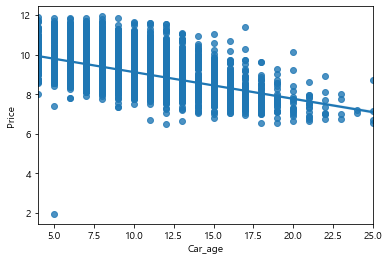

In [74]:
# Price vs Car_age
sns.regplot(x='Car_age', y='Price', data=df_raw)

<AxesSubplot:xlabel='Car_age', ylabel='Price'>

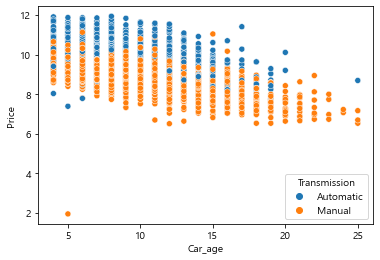

In [75]:
# Price vs Car_age
sns.scatterplot(x='Car_age', y='Price', hue='Transmission', data=df_raw)

<AxesSubplot:xlabel='Car_age', ylabel='Price'>

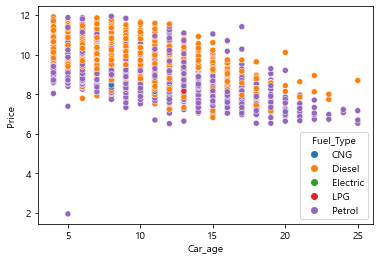

In [76]:
# Price vs Car_age
sns.scatterplot(x='Car_age', y='Price', hue='Fuel_Type', data=df_raw)

<AxesSubplot:title={'center':'the price of the year by the transmission'}, xlabel='Year', ylabel='Price'>

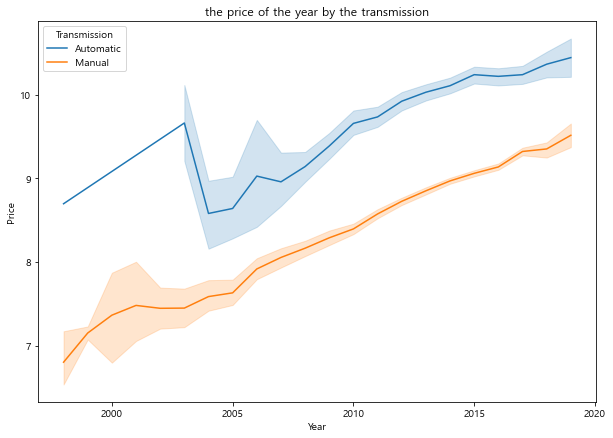

In [77]:
# Impact on the price of the year by the transmission
plt.figure(figsize=(10,7))
plt.title("the price of the year by the transmission")
sns.lineplot(x='Year', y='Price', hue='Transmission', data=df_raw)

<AxesSubplot:title={'center':'the price of the year by the Fuel_Type'}, xlabel='Year', ylabel='Price'>

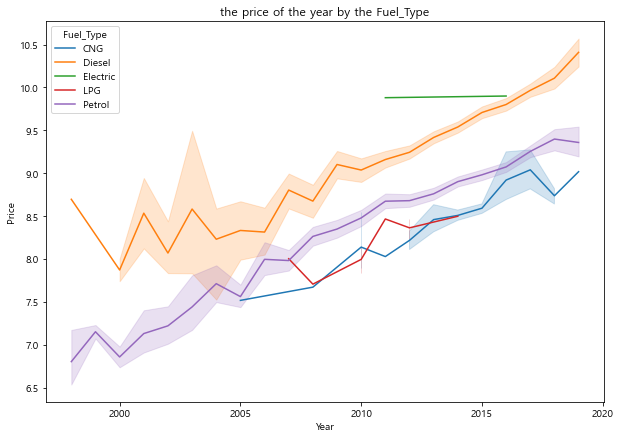

In [78]:
# Impact on the price of the year by the Fuel_Type
plt.figure(figsize=(10,7))
plt.title("the price of the year by the Fuel_Type")
sns.lineplot(x='Year', y='Price', hue='Fuel_Type', data=df_raw)

<AxesSubplot:title={'center':'he price of the year by the Owner_Type'}, xlabel='Year', ylabel='Price'>

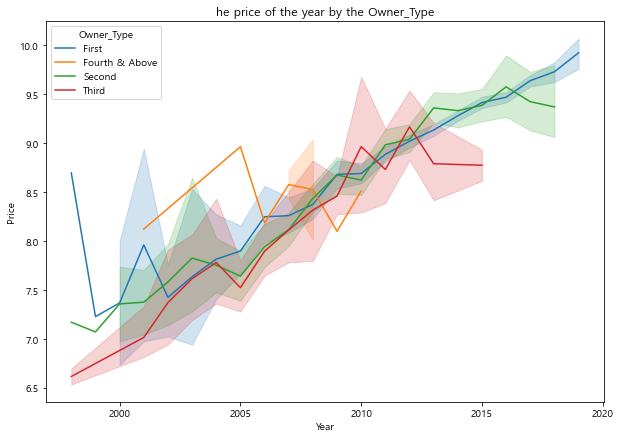

In [79]:
# Impact on the price of the year by the Owner_Type
plt.figure(figsize=(10,7))
plt.title("he price of the year by the Owner_Type")
sns.lineplot(x='Year', y='Price',hue='Owner_Type',data=df_raw)

### STEP 3. EDA – 통계분석

In [83]:
# 가설검정 및 통계 분석 패키지
from scipy import stats

# 선형 회귀모델 formula(y ~ X1 + X2 + ...)
import statsmodels.formula.api as smf

# ANOVA 분석 패키지
from statsmodels.stats.anova import anova_lm

In [86]:
# ANOVA 분석 : 범주형 변수(Transmission,Fuel_Type,Owner_Type,Location,Brand)
formula = 'Price ~ Transmission+Fuel_Type+Owner_Type+Location+Brand'
lm = smf.ols(formula, df_raw).fit()

print(anova_lm(lm))

                  df       sum_sq      mean_sq            F         PR(>F)
Transmission     1.0  1792.732897  1792.732897  7577.919895   0.000000e+00
Fuel_Type        4.0   587.447726   146.861931   620.788492   0.000000e+00
Owner_Type       3.0   158.736795    52.912265   223.661264  1.032511e-137
Location        10.0   211.553480    21.155348    89.424104  5.090816e-173
Brand           28.0   626.148505    22.362447    94.526535   0.000000e+00
Residual      6142.0  1453.032706     0.236573          NaN            NaN


      ▶ 중고차 가격에 Transmission, Fuel_Type, Owner_Type, Location, Brand 변수는 통계적으로 유의미함 
         즉 영향을 준다고 할 수 있다

In [87]:
df_raw.head()

,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Car_age
0,Mumbai,7.894572,2010,11.184421,CNG,Manual,First,26.60,998.0,58.16,5.0,Maruti,13
1,Pune,9.860684,2015,10.621327,Diesel,Manual,First,19.67,1582.0,126.20,5.0,Hyundai,8
2,Chennai,8.839033,2011,10.736397,Petrol,Manual,First,18.20,1199.0,88.70,5.0,Honda,12
3,Chennai,9.126715,2012,11.373663,Diesel,Manual,First,20.77,1248.0,88.76,7.0,Maruti,11
4,Coimbatore,10.210778,2013,10.613246,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,Audi,10


- 범주형 변수의 One Hot Encoding 반영 : pd.get_dummies

In [88]:
df_dummy = pd.get_dummies(df_raw[['Location','Fuel_Type','Transmission',
                                  'Owner_Type','Brand']])
df_dummy.head()

,Location_Ahmedabad,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,...,Brand_Mitsubishi,Brand_Nissan,Brand_Porsche,Brand_Renault,Brand_Skoda,Brand_Smart,Brand_Tata,Brand_Toyota,Brand_Volkswagen,Brand_Volvo
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- Data 결합

In [89]:
# 기존 Data(df_raw)와 범주형 변수의 One Hot Encoding 처리 Data와 결합
df_tot = pd.concat([df_raw, df_dummy], axis=1)
df_tot=df_tot.drop(['Location','Fuel_Type','Transmission','Owner_Type',
                    'Brand'], axis=1)
df_tot

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Car_age,Location_Ahmedabad,Location_Bangalore,...,Brand_Mitsubishi,Brand_Nissan,Brand_Porsche,Brand_Renault,Brand_Skoda,Brand_Smart,Brand_Tata,Brand_Toyota,Brand_Volkswagen,Brand_Volvo
0,7.894572,2010,11.184421,26.60,998.0,58.16,5.0,13,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9.860684,2015,10.621327,19.67,1582.0,126.20,5.0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8.839033,2011,10.736397,18.20,1199.0,88.70,5.0,12,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9.126715,2012,11.373663,20.77,1248.0,88.76,7.0,11,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10.210778,2013,10.613246,15.20,1968.0,140.80,5.0,10,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6184,9.289401,2016,10.631350,27.28,1047.0,69.00,5.0,7,0,0,...,0,0,0,0,0,0,1,0,0,0
6185,9.508571,2017,10.571701,17.00,1497.0,121.36,5.0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
6186,10.234177,2018,8.699515,16.00,1368.0,160.00,5.0,5,0,0,...,0,0,0,0,0,0,0,0,0,0
6187,9.692976,2017,9.970211,24.30,1248.0,88.50,5.0,6,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
#df_tot.rename(columns={df.columns[-3]:'FourthAbove'}, inplace=True)
#df_tot.head()

### STEP 4. 모델 생성 : Linear Regression(statsmodels 패키지 사용)

- STEP 0 패키지 불러오기

In [91]:
# 선형 회귀모델 formula(y ~ X1 + X2 + ...)
import statsmodels.formula.api as smf

# 잔차의 정규성 확인 :qqplot, 회귀분석의 상수항 추가 : add_constant
from statsmodels.api import qqplot, add_constant

# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 학습용/평가용 데이터 분리:train, test
from sklearn.model_selection import train_test_split

# 선형회귀모형
from sklearn.linear_model import LinearRegression

# Scale 변환->표준화 회귀계수 산출
from sklearn.preprocessing import StandardScaler

# 평가함수
from sklearn.metrics import r2_score

- 데이터 구성

In [92]:
df_tot.rename(columns={df_tot.columns[-12]:'Brand_Benz',
                       df_tot.columns[-32]:'Owner_FourthAbove'}, inplace=True)
df_tot.head(2)

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Car_age,Location_Ahmedabad,Location_Bangalore,...,Brand_Mitsubishi,Brand_Nissan,Brand_Porsche,Brand_Renault,Brand_Skoda,Brand_Smart,Brand_Tata,Brand_Toyota,Brand_Volkswagen,Brand_Volvo
0,7.894572,2010,11.184421,26.60,998.0,58.16,5.0,13,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9.860684,2015,10.621327,19.67,1582.0,126.20,5.0,8,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
# train/test data 분리
df_train, df_test = train_test_split(df_tot, test_size = 0.3, random_state = 1234) 
print("train data size :{}".format(df_train.shape))
print("test data size : {}".format(df_test.shape))

train data size :(4332, 59)
test data size : (1857, 59)


In [94]:
df_train.head(2)

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Car_age,Location_Ahmedabad,Location_Bangalore,...,Brand_Mitsubishi,Brand_Nissan,Brand_Porsche,Brand_Renault,Brand_Skoda,Brand_Smart,Brand_Tata,Brand_Toyota,Brand_Volkswagen,Brand_Volvo
3651,8.816560,2016,11.572062,24.4,1120.0,71.00,5.0,7,0,0,...,0,0,0,0,0,0,0,0,0,0
744,10.491956,2014,11.002100,20.7,1496.0,113.98,5.0,9,0,0,...,0,0,0,0,0,0,0,0,0,0


In [95]:
df_train.columns

Index(['Price', 'Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power',
       'Seats', 'Car_age', 'Location_Ahmedabad', 'Location_Bangalore',
       'Location_Chennai', 'Location_Coimbatore', 'Location_Delhi',
       'Location_Hyderabad', 'Location_Jaipur', 'Location_Kochi',
       'Location_Kolkata', 'Location_Mumbai', 'Location_Pune', 'Fuel_Type_CNG',
       'Fuel_Type_Diesel', 'Fuel_Type_Electric', 'Fuel_Type_LPG',
       'Fuel_Type_Petrol', 'Transmission_Automatic', 'Transmission_Manual',
       'Owner_Type_First', 'Owner_FourthAbove', 'Owner_Type_Second',
       'Owner_Type_Third', 'Brand_Ambassador', 'Brand_Audi', 'Brand_BMW',
       'Brand_Bentley', 'Brand_Chevrolet', 'Brand_Datsun', 'Brand_Fiat',
       'Brand_Force', 'Brand_Ford', 'Brand_Honda', 'Brand_Hyundai',
       'Brand_ISUZU', 'Brand_Jaguar', 'Brand_Jeep', 'Brand_Land',
       'Brand_Mahindra', 'Brand_Maruti', 'Brand_Benz', 'Brand_Mini',
       'Brand_Mitsubishi', 'Brand_Nissan', 'Brand_Porsche', 'Brand_Renault',
  

- 회귀 모델 생성: 설명변수 전체

In [96]:
# 선형 회귀 분석 
formula = "Price ~ Year + Kilometers_Driven + Mileage + Engine + Power + Seats \
                 + Car_age + Location_Ahmedabad + Location_Bangalore + Location_Chennai + Location_Coimbatore \
                 + Location_Delhi + Location_Hyderabad + Location_Jaipur \
                 + Location_Kochi + Location_Kolkata + Location_Mumbai + Location_Pune\
                 + Fuel_Type_CNG + Fuel_Type_Diesel + Fuel_Type_Electric + Fuel_Type_LPG \
                 + Fuel_Type_Petrol + Transmission_Automatic + Transmission_Manual + Owner_Type_First \
                 + Owner_FourthAbove + Owner_Type_Second + Owner_Type_Third + Brand_Ambassador + Brand_Audi \
                 + Brand_BMW + Brand_Bentley + Brand_Chevrolet + Brand_Datsun + Brand_Fiat + Brand_Force \
                 + Brand_Ford + Brand_Honda + Brand_Hyundai + Brand_ISUZU + Brand_Jaguar \
                 + Brand_Jeep + Brand_Land + Brand_Mahindra + Brand_Maruti + Brand_Benz \
                 + Brand_Mini + Brand_Mitsubishi + Brand_Nissan + Brand_Porsche + Brand_Renault \
                 + Brand_Skoda + Brand_Smart + Brand_Tata + Brand_Volkswagen + Brand_Volvo" 
reg_model = smf.ols(formula, data=df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     848.1
Date:                Fri, 13 Jan 2023   Prob (F-statistic):               0.00
Time:                        08:59:22   Log-Likelihood:                -390.82
No. Observations:                4332   AIC:                             885.6
Df Residuals:                    4280   BIC:                             1217.
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -5.46

- 회귀 모델 생성:설명변수 다중공선성 처리

In [97]:
# 목표변수, 설명변수 데이터 지정
df_train_y = df_train["Price"]
df_train_x = df_train.drop(columns=["Price"], axis = 1)

# statsmodels의 상수항 추가 함수 적용
df_train_x_const = add_constant(df_train_x) 

# DataFrame으로 저장
df_vif = pd.DataFrame()
df_vif["Variable"] = df_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_x_const.values, i)\
                 for i in range(df_train_x_const.shape[1])]

# VIF 정렬
df_vif.sort_values(by="VIF", ascending = True).round(2)

,Variable,VIF
0,const,0.00
2,Kilometers_Driven,1.79
6,Seats,2.46
3,Mileage,3.85
5,Power,9.00
4,Engine,10.17
42,Brand_Jaguar,inf
41,Brand_ISUZU,inf
40,Brand_Hyundai,inf
39,Brand_Honda,inf


- 회귀 모델 생성: 유의한 설명변수 확인

In [99]:
# 선형 회귀 분석:formula(y ~ X1 + X2 +...) 이용. 상수항(Intercept) 자동 추가
formula = "Price ~ Year + Kilometers_Driven + Mileage + Engine + Power + Seats \
           + Car_age + Location_Ahmedabad + Location_Bangalore + Location_Chennai \
           + Location_Coimbatore + Location_Hyderabad + Location_Jaipur \
           + Location_Kolkata + Fuel_Type_CNG  + Fuel_Type_Electric + Fuel_Type_LPG \
           + Fuel_Type_Petrol + Transmission_Automatic + Transmission_Manual + Owner_Type_First \
           + Owner_Type_Third + Brand_Audi + Brand_BMW + Brand_Chevrolet + Brand_Datsun \
           + Brand_Fiat + Brand_Ford + Brand_Hyundai + Brand_ISUZU + Brand_Jaguar \
           + Brand_Land + Brand_Mahindra + Brand_Benz + Brand_Mini + Brand_Nissan + Brand_Porsche \
           + Brand_Renault + Brand_Tata + Brand_Volkswagen + Brand_Volvo" 
reg_model = smf.ols(formula, data=df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     1080.
Date:                Fri, 13 Jan 2023   Prob (F-statistic):               0.00
Time:                        08:59:54   Log-Likelihood:                -448.05
No. Observations:                4332   AIC:                             976.1
Df Residuals:                    4292   BIC:                             1231.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -5.55

In [100]:
# Brand_Smart, Fuel_Type_Diesel, Brand_Ambassador, Brand_Bentley, Brand_Jeep, Owner_Type_Second, 
# Owner_FourthAbove, Brand_Mitsubishi, Location_Mumbai, Location_Kochi, Location_Pune, Brand_Force, 
# Brand_Maruti, Brand_Honda,Brand_Skoda, Brand_Toyota, Location_Delhi 

In [101]:
# 목표변수, 설명변수 데이터 지정
df_train_y = df_train["Price"]
df_train_x = df_train.drop(columns=["Price","Brand_Smart","Fuel_Type_Diesel","Brand_Ambassador",
                                    "Brand_Bentley","Brand_Jeep","Owner_Type_Second","Owner_FourthAbove",
                                    "Brand_Mitsubishi","Location_Mumbai","Location_Kochi",
                                    "Location_Pune","Brand_Force","Brand_Maruti","Brand_Honda",
                                    "Brand_Skoda",'Brand_Toyota',"Location_Delhi"], axis = 1)

# statsmodels의 상수항 추가 함수 적용
df_train_x_const = add_constant(df_train_x) 

# DataFrame으로 저장
df_vif = pd.DataFrame()
df_vif["Variable"] = df_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_x_const.values, i)\
                 for i in range(df_train_x_const.shape[1])]

# VIF 정렬
df_vif.sort_values(by="VIF", ascending = True).round(2)

,Variable,VIF
0,const,0.00
16,Fuel_Type_Electric,1.01
30,Brand_ISUZU,1.01
26,Brand_Datsun,1.02
27,Brand_Fiat,1.02
17,Fuel_Type_LPG,1.02
36,Brand_Nissan,1.04
25,Brand_Chevrolet,1.05
41,Brand_Volvo,1.05
35,Brand_Mini,1.06


- 회귀 모델 생성: 모델의 성능

In [102]:
# 평가용 데이터에 대한 성능 확인
train_pred = reg_result.predict(df_train)
test_pred = reg_result.predict(df_test)
print("train data의 결정계수:", r2_score(df_train['Price'], train_pred))
print("test data의 결정계수:", r2_score(df_test['Price'], test_pred))

train data의 결정계수: 0.9075471328872573
test data의 결정계수: 0.8685413321801074


### STEP 5. 결론 도출(statsmodels 패키지 사용)

- 변수 중요도 확인 : 회귀계수 기준

In [103]:
df_train_x_const.columns

Index(['const', 'Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power',
       'Seats', 'Car_age', 'Location_Ahmedabad', 'Location_Bangalore',
       'Location_Chennai', 'Location_Coimbatore', 'Location_Hyderabad',
       'Location_Jaipur', 'Location_Kolkata', 'Fuel_Type_CNG',
       'Fuel_Type_Electric', 'Fuel_Type_LPG', 'Fuel_Type_Petrol',
       'Transmission_Automatic', 'Transmission_Manual', 'Owner_Type_First',
       'Owner_Type_Third', 'Brand_Audi', 'Brand_BMW', 'Brand_Chevrolet',
       'Brand_Datsun', 'Brand_Fiat', 'Brand_Ford', 'Brand_Hyundai',
       'Brand_ISUZU', 'Brand_Jaguar', 'Brand_Land', 'Brand_Mahindra',
       'Brand_Benz', 'Brand_Mini', 'Brand_Nissan', 'Brand_Porsche',
       'Brand_Renault', 'Brand_Tata', 'Brand_Volkswagen', 'Brand_Volvo'],
      dtype='object')

In [104]:
reg_result.params.values[1:]

array([ 5.05021886e-03, -5.74767465e-02, -1.90161700e-02,  2.24193676e-04,
        4.50821121e-03,  5.53314111e-02, -1.17471132e-01,  5.41942151e-02,
        1.65449219e-01,  4.64249041e-02,  1.17907667e-01,  1.33040942e-01,
       -4.58201129e-02, -1.93483042e-01, -2.89897904e-01,  9.61212105e-01,
       -3.15474635e-01, -2.97313471e-01,  6.13106328e-02, -6.13662042e-02,
        6.62455332e-02, -7.69367693e-02,  5.09474511e-01,  4.92554935e-01,
       -3.66477046e-01, -3.84575012e-01, -3.38436188e-01, -1.59062996e-01,
       -5.10973049e-02, -4.32755679e-01,  5.28723137e-01,  8.00502997e-01,
       -2.74576244e-01,  5.26252370e-01,  1.01686376e+00, -9.37439703e-02,
        3.85871803e-01, -1.02766086e-01, -5.46195989e-01, -7.56166644e-02,
        3.07534272e-01])

In [105]:
df_reg_coef = pd.DataFrame({'Variable':['Year','Kilometers_Driven', 'Mileage', 'Engine', 'Power',
                                     'Seats','Car_age','Location_Ahmedabad', 'Location_Bangalore',
                                     'Location_Chennai','Location_Coimbatore', 
                                     'Location_Hyderabad','Location_Jaipur', 'Location_Kolkata',
                                     'Fuel_Type_CNG','Fuel_Type_Electric', 'Fuel_Type_LPG',
                                     'Fuel_Type_Petrol','Transmission_Automatic', 'Transmission_Manual',
                                     'Owner_Type_First','Owner_Type_Third', 'Brand_Audi', 'Brand_BMW',
                                     'Brand_Chevrolet','Brand_Datsun', 'Brand_Fiat', 'Brand_Ford',
                                     'Brand_Hyundai','Brand_ISUZU', 'Brand_Jaguar',
                                     'Brand_Land','Brand_Mahindra', 'Brand_Benz', 'Brand_Mini',
                                     'Brand_Nissan','Brand_Porsche', 'Brand_Renault',
                                     'Brand_Tata','Brand_Volkswagen','Brand_Volvo'],
                            "Coef": reg_result.params.values[1:]})

In [106]:
df_reg_coef.sort_values('Coef', ascending=False, inplace=True)
df_reg_coef.round(3)

,Variable,Coef
34,Brand_Mini,1.017
15,Fuel_Type_Electric,0.961
31,Brand_Land,0.801
30,Brand_Jaguar,0.529
33,Brand_Benz,0.526
22,Brand_Audi,0.509
23,Brand_BMW,0.493
36,Brand_Porsche,0.386
40,Brand_Volvo,0.308
8,Location_Bangalore,0.165


- 설명변수 중요도 확인

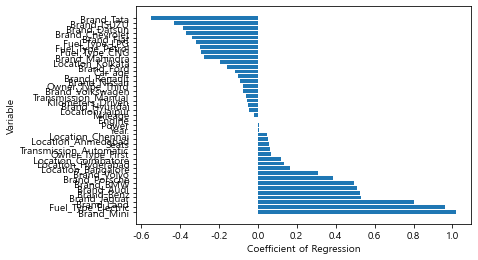

In [107]:
df_reg_coef.sort_values('Coef', ascending=False, inplace=True)
coodinates=range(len(df_reg_coef))
plt.barh(y=coodinates, width=df_reg_coef["Coef"])
plt.yticks(coodinates, df_reg_coef["Variable"])
plt.xlabel("Coefficient of Regression") ; plt.ylabel("Variable")
plt.show()

### STEP 4. 모델 생성 : Linear Regression(sklearn 사용)

In [108]:
# 목표변수, 설명변수 데이터 지정
df_y = df_tot["Price"]
df_x = df_tot.drop("Price", axis=1)

In [109]:
# 데이터 분할 (train, test 데이터 7:3 비율로 분할)
# train_test_split(X,Y:,test_size, random_state: random seed)
train_x, test_x, train_y, test_y = train_test_split(df_x, df_y   
                                   ,test_size = 0.3, random_state = 1234) 

print("train data X size : {}".format(train_x.shape))
print("train data Y size : {}".format(train_y.shape))
print("test data X size :  {}".format(test_x.shape))
print("test data Y size :  {}".format(test_y.shape))

train data X size : (4332, 58)
train data Y size : (4332,)
test data X size :  (1857, 58)
test data Y size :  (1857,)


In [110]:
lr_model = LinearRegression()
lr_model.fit(train_x, train_y)

LinearRegression()

In [111]:
df_x.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Car_age,Location_Ahmedabad,Location_Bangalore,Location_Chennai,...,Brand_Mitsubishi,Brand_Nissan,Brand_Porsche,Brand_Renault,Brand_Skoda,Brand_Smart,Brand_Tata,Brand_Toyota,Brand_Volkswagen,Brand_Volvo
0,2010,11.184421,26.60,998.0,58.16,5.0,13,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2015,10.621327,19.67,1582.0,126.20,5.0,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2011,10.736397,18.20,1199.0,88.70,5.0,12,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2012,11.373663,20.77,1248.0,88.76,7.0,11,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2013,10.613246,15.20,1968.0,140.80,5.0,10,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [112]:
print(lr_model.coef_)

[ 6.04170147e-02 -5.62771299e-02 -1.44233381e-02  1.57802856e-04
  4.87133736e-03  5.30111368e-02 -6.04170147e-02  2.68823758e-02
  1.44055300e-01  2.01950924e-02  9.30720663e-02 -5.45006750e-02
  1.09794849e-01 -6.41790026e-02 -1.37100329e-02 -2.19743623e-01
 -1.21709861e-02 -2.96953643e-02 -2.65941409e-01  2.74501878e-03
  8.28674056e-01 -2.86457684e-01 -2.79019982e-01  6.12308364e-02
 -6.12308364e-02  4.69292903e-02  7.20805603e-02 -2.10557880e-02
 -9.79540626e-02  1.18407521e-02  4.39170857e-01  4.05357112e-01
  8.76962923e-02 -4.88212182e-01 -5.30455605e-01 -4.60631940e-01
 -2.08166817e-16 -2.61698106e-01 -1.24504551e-01 -1.79312834e-01
 -4.46706704e-01  4.67361504e-01  7.62317115e-02  7.52322290e-01
 -3.21417919e-01 -1.80105003e-01  4.59481141e-01  9.03077252e-01
  9.98657058e-02 -2.10363101e-01  3.42460168e-01 -2.30481419e-01
 -7.64678951e-02  4.24601348e-02 -6.61371639e-01  4.46039309e-02
 -1.89600181e-01  2.29400225e-01]


In [113]:
print(lr_model.intercept_)

-111.90045521057206


In [114]:
train_x.columns

Index(['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats',
       'Car_age', 'Location_Ahmedabad', 'Location_Bangalore',
       'Location_Chennai', 'Location_Coimbatore', 'Location_Delhi',
       'Location_Hyderabad', 'Location_Jaipur', 'Location_Kochi',
       'Location_Kolkata', 'Location_Mumbai', 'Location_Pune', 'Fuel_Type_CNG',
       'Fuel_Type_Diesel', 'Fuel_Type_Electric', 'Fuel_Type_LPG',
       'Fuel_Type_Petrol', 'Transmission_Automatic', 'Transmission_Manual',
       'Owner_Type_First', 'Owner_FourthAbove', 'Owner_Type_Second',
       'Owner_Type_Third', 'Brand_Ambassador', 'Brand_Audi', 'Brand_BMW',
       'Brand_Bentley', 'Brand_Chevrolet', 'Brand_Datsun', 'Brand_Fiat',
       'Brand_Force', 'Brand_Ford', 'Brand_Honda', 'Brand_Hyundai',
       'Brand_ISUZU', 'Brand_Jaguar', 'Brand_Jeep', 'Brand_Land',
       'Brand_Mahindra', 'Brand_Maruti', 'Brand_Benz', 'Brand_Mini',
       'Brand_Mitsubishi', 'Brand_Nissan', 'Brand_Porsche', 'Brand_Renault',
       'Bra

In [115]:
# Train 데이터 설명력
print("Score on training set:{:.3f}".format(lr_model.score(train_x, train_y)))

# Test 데이터 설명력
print("Score on test set:{:.3f}".format(lr_model.score(test_x, test_y)))

Score on training set:0.910
Score on test set:0.870


- 모델의 성능 확인

In [116]:
# 예측값 생성
train_pred = lr_model.predict(train_x)
test_pred = lr_model.predict(test_x)

In [117]:
# 평가용 데이터에 대한 성능 확인
print("train data의 결정계수:", r2_score(train_y, train_pred))
print("test data의 결정계수:", r2_score(test_y, test_pred))

train data의 결정계수: 0.909957893775891
test data의 결정계수: 0.8700976971534232


In [118]:
print("Prediction for test set: {}".format(test_pred))

Prediction for test set: [ 8.19009011  8.61818776 10.45716115 ...  8.70730634  8.12404456
  8.8635051 ]


In [119]:
# Actual value and the predicted value
# reg_model_diff = pd.DataFrame({'Actual value': test_x, 'Predicted value': test_pred})
# reg_model_diff

### STEP 5. 결론 도출(sklearn 사용)

In [120]:
# 설명변수 중요도(표준화 적용 이전) -> 표준화 회귀계수 산출해야 함 
lr_reg_coef = pd.DataFrame({"Coef": lr_model.coef_},index=train_x.columns)

df_reg_coef.sort_values('Coef', ascending=False, inplace=True)
df_reg_coef.round(3)

,Variable,Coef
34,Brand_Mini,1.017
15,Fuel_Type_Electric,0.961
31,Brand_Land,0.801
30,Brand_Jaguar,0.529
33,Brand_Benz,0.526
22,Brand_Audi,0.509
23,Brand_BMW,0.493
36,Brand_Porsche,0.386
40,Brand_Volvo,0.308
8,Location_Bangalore,0.165


- 설명변수 중요도 확인

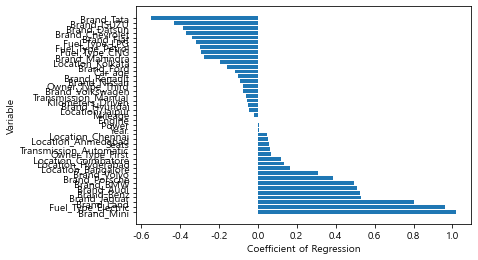

In [121]:
# 설명변수 중요도 
df_reg_coef.sort_values('Coef', ascending=False, inplace=True)
coodinates=range(len(df_reg_coef))
plt.barh(y=coodinates, width=df_reg_coef["Coef"])
plt.yticks(coodinates, df_reg_coef["Variable"])
plt.xlabel("Coefficient of Regression") ; plt.ylabel("Variable")
plt.show()

### STEP 4. 모델 생성 : Decision Tree

In [122]:
# 예측/회귀 Decision Tree
from sklearn.tree import DecisionTreeRegressor

# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

In [123]:
# Random Forest 모델 생성 및 학습
dt_model=DecisionTreeRegressor()
dt_model.fit(train_x, train_y)

DecisionTreeRegressor()

In [124]:
# train data score 확인
train_pred=dt_model.predict(train_x)
dt_model.score(train_x, train_y)

0.9999887940273128

In [125]:
# test data score 확인
test_pred=dt_model.predict(test_x)
dt_model.score(test_x, test_y)

0.8285711894387232

- GridSearchCV를 이용한 최적 parameter/model 찾기

In [126]:
param_grid = {'max_depth':range(2,10),
              'min_samples_split':range(2,40, 2),
              'min_samples_leaf':range(2,20, 2)}

In [127]:
grid_dt = GridSearchCV(dt_model, param_grid, cv=3, n_jobs=-1)
grid_dt.fit(train_x, train_y)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(2, 10),
                         'min_samples_leaf': range(2, 20, 2),
                         'min_samples_split': range(2, 40, 2)})

In [128]:
print("best model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))
print("\ntest_set score: \n{}".format(grid_dt.score(test_x, test_y).round(3)))

best model: 
DecisionTreeRegressor(max_depth=9, min_samples_leaf=6, min_samples_split=16)

best parameter: 
{'max_depth': 9, 'min_samples_leaf': 6, 'min_samples_split': 16}

best score: 
0.859

test_set score: 
0.837


- 최종 모델

In [129]:
tree_final = DecisionTreeRegressor(min_samples_leaf = 6, min_samples_split = 16, 
                                   max_depth = 9, random_state=1234)
tree_final.fit(train_x, train_y)

DecisionTreeRegressor(max_depth=9, min_samples_leaf=6, min_samples_split=16,
                      random_state=1234)

In [130]:
# Train 데이터 설명력
print("Score on training set:{:.3f}".format(tree_final.score(train_x, train_y)))

# Test 데이터 설명력
print("Score on test set:{:.3f}".format(tree_final.score(test_x, test_y)))

Score on training set:0.919
Score on test set:0.839


- feature_importances_: 설명변수의 중요도

In [131]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = train_x.columns
df_importance["Importance"] = tree_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
4,Power,0.651
0,Year,0.224
3,Engine,0.042
6,Car_age,0.029
2,Mileage,0.016
38,Brand_Honda,0.005
1,Kilometers_Driven,0.005
15,Location_Kolkata,0.004
44,Brand_Mahindra,0.004
23,Transmission_Automatic,0.002


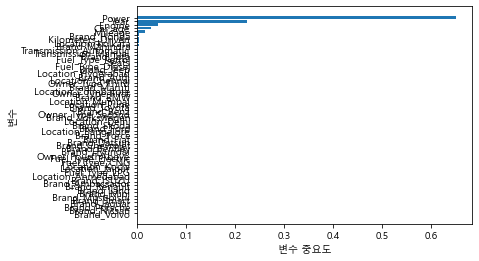

In [132]:
# 설명변수 중요도 그래프 
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도") ;  plt.ylabel("변수")
plt.show()

      ▶ 중요 설명변수: Power, Year, Engine, Car_age, Kilometers_Driven, Mileage, 
         Transmission_Automatic 순으로 영향이 크다고 해석할 수 있음
      ▶ 단, 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 데이터에 따라 중요도가 변경될 수 있음

### STEP 4. 모델 생성 : Random Forest

In [133]:
from sklearn.ensemble import RandomForestRegressor

In [134]:
# Random Forest 모델 생성 및 학습
rf_model = RandomForestRegressor()
rf_model.fit(train_x, train_y)

RandomForestRegressor()

In [135]:
# train data score 확인
train_pred=rf_model.predict(train_x)
rf_model.score(train_x, train_y)

0.9877138537179793

In [136]:
# test data score 확인
test_pred=rf_model.predict(test_x)
rf_model.score(test_x, test_y)

0.8883501729209384

- GridSearchCV를 이용한 최적 parameter/model 찾기

In [137]:
param_grid = {'max_depth':range(2,10),
              'min_samples_split':range(2,40, 2),
              'min_samples_leaf':range(2,20, 2)}

In [138]:
grid_rf = GridSearchCV(rf_model, param_grid, cv=3, n_jobs = -1)
grid_rf.fit(train_x, train_y)

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(2, 10),
                         'min_samples_leaf': range(2, 20, 2),
                         'min_samples_split': range(2, 40, 2)})

In [139]:
print("best model: \n{}".format(grid_rf.best_estimator_))
print("\nbest parameter: \n{}".format(grid_rf.best_params_))
print("\nbest score: \n{}".format(grid_rf.best_score_.round(3)))
print("\ntest_set score: \n{}".format(grid_rf.score(test_x, test_y).round(3)))

best model: 
RandomForestRegressor(max_depth=9, min_samples_leaf=2, min_samples_split=8)

best parameter: 
{'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 8}

best score: 
0.895

test_set score: 
0.877


- 최종 모델

In [140]:
rf_final = RandomForestRegressor(min_samples_leaf = 2, min_samples_split = 8, 
                                   max_depth = 9, random_state=1234)
rf_final.fit(train_x, train_y)

RandomForestRegressor(max_depth=9, min_samples_leaf=2, min_samples_split=8,
                      random_state=1234)

In [141]:
# Train 데이터 설명력
print("Score on training set:{:.3f}".format(rf_final.score(train_x, train_y)))

# Test 데이터 설명력
print("Score on test set:{:.3f}".format(rf_final.score(test_x, test_y)))

Score on training set:0.942
Score on test set:0.877


- feature_importances: 설명변수의 중요도

In [142]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = train_x.columns
df_importance["Importance"] = rf_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
4,Power,0.634
0,Year,0.126
6,Car_age,0.122
3,Engine,0.045
2,Mileage,0.011
1,Kilometers_Driven,0.010
44,Brand_Mahindra,0.004
43,Brand_Land,0.004
38,Brand_Honda,0.004
54,Brand_Tata,0.003


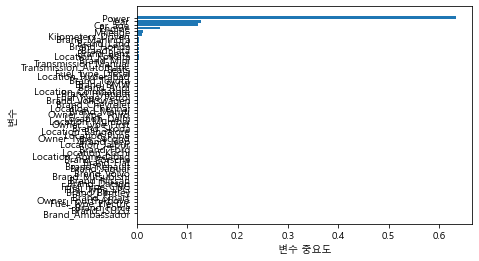

In [143]:
# 설명변수 중요도 그래프 
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도") ;  plt.ylabel("변수")
plt.show()

       ▶ 중요 설명변수: Power, Year, Engine, Car_age, Kilometers_Driven, Mileage, 
                        Transmission_Automatic 순으로 영향이 크다고 해석할 수 있음
       ▶ 단, 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 데이터에 따라 중요도가 변경될 수 있음

### STEP 4. 모델 생성 : Gradient Boosting 

In [144]:
from sklearn.ensemble import GradientBoostingRegressor

In [145]:
# Random Forest 모델 생성 및 학습
gb_model =  GradientBoostingRegressor()
gb_model.fit(train_x, train_y)

GradientBoostingRegressor()

In [146]:
# train data score 확인
train_pred = gb_model.predict(train_x)
gb_model.score(train_x, train_y)

0.9343235320364556

In [147]:
# test data score 확인
test_pred = gb_model.predict(test_x)
gb_model.score(test_x, test_y)

0.8826942594732493

- GridSearchCV를 이용한 최적 parameter/model 찾기

In [148]:
param_grid = {'max_depth':range(2,10),
              'min_samples_split':range(2,40, 2),
              'min_samples_leaf':range(2,20, 2)}

In [149]:
grid_gb = GridSearchCV(gb_model, param_grid, cv=3, n_jobs=-1)
grid_gb.fit(train_x, train_y)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(2, 10),
                         'min_samples_leaf': range(2, 20, 2),
                         'min_samples_split': range(2, 40, 2)})

In [150]:
print("best model: \n{}".format(grid_gb.best_estimator_))
print("\nbest parameter: \n{}".format(grid_gb.best_params_))
print("\nbest score: \n{}".format(grid_gb.best_score_.round(3)))
print("\ntest_set score: \n{}".format(grid_gb.score(test_x, test_y).round(3)))

best model: 
GradientBoostingRegressor(max_depth=7, min_samples_leaf=6, min_samples_split=24)

best parameter: 
{'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 24}

best score: 
0.92

test_set score: 
0.895


- 최종 모델

In [151]:
gb_final = GradientBoostingRegressor(min_samples_leaf = 6, min_samples_split = 24, 
                                     max_depth = 7, random_state=1234)
gb_final.fit(train_x, train_y)

GradientBoostingRegressor(max_depth=7, min_samples_leaf=6, min_samples_split=24,
                          random_state=1234)

In [152]:
# Train 데이터 설명력
print("Score on training set:{:.3f}".format(gb_final.score(train_x, train_y)))

# Test 데이터 설명력
print("Score on test set:{:.3f}".format(gb_final.score(test_x, test_y)))

Score on training set:0.972
Score on test set:0.895


- feature_importances: 설명변수의 중요도

In [153]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = train_x.columns
df_importance["Importance"] = gb_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
4,Power,0.603
6,Car_age,0.155
0,Year,0.085
3,Engine,0.045
2,Mileage,0.016
1,Kilometers_Driven,0.015
24,Transmission_Manual,0.010
23,Transmission_Automatic,0.006
44,Brand_Mahindra,0.006
15,Location_Kolkata,0.005


Text(0, 0.5, '변수')

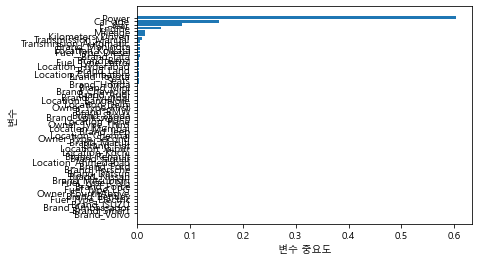

In [154]:
# 설명변수 중요도 그래프 
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도") ;  plt.ylabel("변수")

     ▶ 중요 설명변수: Power, Car_age, Year, Engine, Kilometers_Driven, Mileage, Brand_Land, 
        Brand_Mini, Benz, Transmission_Automatic, Manual 순으로 영향이 크다고 해석할 수 있음
     ▶ 단, 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 데이터에 따라 중요도가 변경될 수 있음

### STEP 6. 예측 모델 평가

In [217]:
# 평가함수
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score
# from statsmodels.tools.eval_measures import rmse

In [218]:
# RMSE:root mean squared error 함수
def root_mean_squared_error(df_test_y, lr_y_pred):
    return np.sqrt(mean_squared_error(df_test_y, lr_y_pred))

In [219]:
df_tot.shape

(6189, 59)

In [220]:
# 목표변수, 설명변수 데이터 지정
df_tot_y = df_tot["Price"]
df_tot_x = df_tot.drop("Price", axis = 1, inplace = False)

In [221]:
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터)
# test_size = test 데이터 비율, random_state: random seed
df_train_x,df_test_x,df_train_y,df_test_y=train_test_split(df_tot_x, df_tot_y,
                                                           test_size = 0.3, random_state = 1234) 
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (4332, 58)
train data Y size : (4332,)
test data X size : (1857, 58)
test data Y size : (1857,)


- 예측 모델 생성

In [222]:
# 회귀 모델
lr_model = LinearRegression()
lr_model.fit(df_train_x, df_train_y)

LinearRegression()

In [224]:
# Decision Tree
dt_model = DecisionTreeRegressor(min_samples_leaf = 6, min_samples_split = 16, 
                                   max_depth = 9, random_state=1234)
dt_model.fit(df_train_x, df_train_y)

# Random Forest
rf_model = RandomForestRegressor(min_samples_leaf = 2, min_samples_split = 8, 
                                   max_depth = 9, random_state=1234)
rf_model.fit(df_train_x, df_train_y)

# Gradient Boosting
gb_model = GradientBoostingRegressor(min_samples_leaf = 6, min_samples_split = 24, 
                                     max_depth = 7, random_state=1234)
gb_model.fit(df_train_x, df_train_y)

GradientBoostingRegressor(max_depth=7, min_samples_leaf=6, min_samples_split=24,
                          random_state=1234)

- 예측 및 평가

In [225]:
# 모델 리스트, 그래프를 그리기 위한 생성 목적
models = ["Regession", "Decision Tree", "Random Forest", "Gradient Boosting"]

# 평가 리스트 초기화
mse, rmse, mae, mape = [], [], [], []

In [226]:
# 1) Regression

# 예측
lr_y_pred = lr_model.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, lr_y_pred))
rmse.append(root_mean_squared_error(df_test_y, lr_y_pred))
mae.append(mean_absolute_error(df_test_y, lr_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, lr_y_pred))

In [227]:
# 2) Decision Tree

# 예측
dt_y_pred = dt_model.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, dt_y_pred))
rmse.append(root_mean_squared_error(df_test_y, dt_y_pred))
mae.append(mean_absolute_error(df_test_y, dt_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, dt_y_pred))

In [228]:
# 3) Random Forest 

# 예측
rf_y_pred = rf_model.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, rf_y_pred))
rmse.append(root_mean_squared_error(df_test_y, rf_y_pred))
mae.append(mean_absolute_error(df_test_y, rf_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, rf_y_pred))

In [229]:
# 4) Gradient Boosting

# 예측
gb_y_pred = gb_model.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, gb_y_pred))
rmse.append(root_mean_squared_error(df_test_y, gb_y_pred))
mae.append(mean_absolute_error(df_test_y, gb_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, gb_y_pred))

- 시각화 : 평가

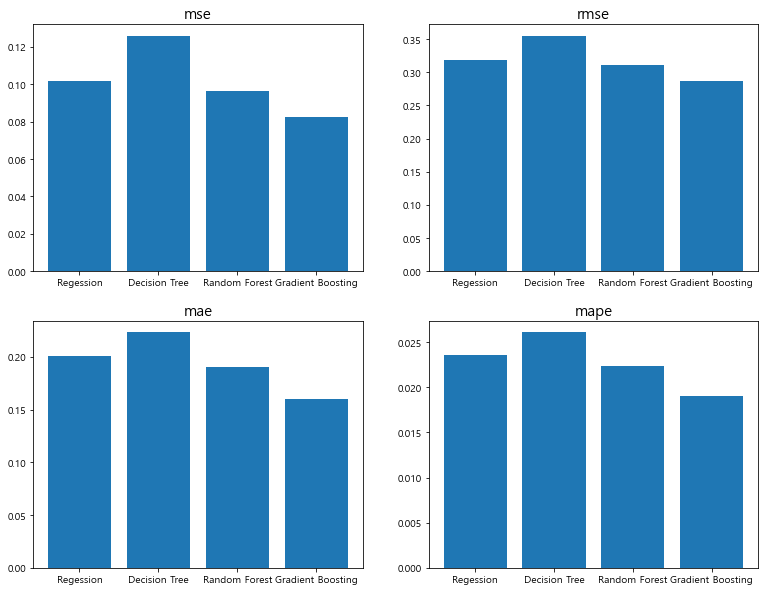

In [230]:
fig, ax = plt.subplots(2,2, figsize = (13,10))
ax[0, 0].bar(models, mse)
ax[0, 0].set_title("mse").set_fontsize(15)

ax[0, 1].bar(models, rmse)
ax[0, 1].set_title("rmse").set_fontsize(15)

ax[1, 0].bar(models, mae)
ax[1, 0].set_title("mae").set_fontsize(15)

ax[1, 1].bar(models, mape)
ax[1, 1].set_title("mape").set_fontsize(15)

     ▶ mse, rmse, mae, mape 평가지표로 평가결과, Gradient Boosting이 가정 적고, 다음은
        Random Forest, Linear Regression, Decision Tree로 나타남.  

### STEP 7. 결론 : Best Model 선정

1. 중고차 가격 예측 모델은 Gradient Boosting 모델로 선정 
   - Modeling후 평가지표(mse, rmse, mae, mape)로 평가결과는 Gradient Boosting 이 가장 적게 나타남
   - tnstj : Gradient Boosting < Random Forest < Linear Regression < Decision Tree
2. Modeling후 성능도 Gradient Boosting 모델이 가장 높게 나타남
   - 순서는 Gradient Boosting(training set:0.972, test set:0.895), Random Forest(training set:0.942, test set:0.877), Linear Regression(training set: 0.910,test set:0.870), Decision Tree(training set:0.919, test set:0.839) 이다.   

### STEP 8. 모델 성능향상  방안
- 중고차 가격 예측 모델 개발 결과물에 대해 부족한 부분과 개선이 필요한 부분 등 검토하여 모델 성능향상방안 정리

1. 목표변수('Price') 결측치에 대해 제거를 하였으나, 대체 방법 추가 검토
2. 설명변수의 분포의 변환 검토  
   - Kilometers_Driven 분포 : 우측으로 기울어짐
   - Car_age, Engine, Power 분포 : 좌측으로 기울어짐
3. Decision Tree, Random Forest, Gradient Boosting에서 hyperparameter tunning 과
   GridSearchCV 에서 parameter의 추가와 범위를 넓여서 최적 parameter/model 찾기가 진행 필요
4. 자동차 가격과 관련된 자료들을 조사하여 추가적인 파생변수의 생성을 검토 등등....  